In [1]:
'''
=====Experiment=====
'''
DATASET_NAME = "BoT_IoT"

GRAPH_CONSTRUCTION = 'host'
WINDOW_SIZE = 3500

MULTICLASS = True

LOAD_SAVED = False

FIRST_RUN = not LOAD_SAVED

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config as Dataset_Config

EXPERIMENT_NAME = f"strat_window_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}"

SOURCE_IP_COL_NAME = Dataset_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = Dataset_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = Dataset_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = Dataset_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = Dataset_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = Dataset_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = Dataset_Config.BENIGN_CLASS_NAME

TIME_COLS = Dataset_Config.TIME_COL_NAMES

DROP_COLS = Dataset_Config.DROP_COLS

COLS_TO_NORM = Dataset_Config.COLS_TO_NORM
CATEGORICAL_COLS = Dataset_Config.CATEGORICAL_COLS

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
else:
    label_col = IS_ATTACK_COL_NAME

save_path = os.path.join(project_root, f"Models/E_GraphSAGE/{DATASET_NAME}/saved", EXPERIMENT_NAME)

checkpoint_path = os.path.join(save_path, f"checkpoints.pth")
best_model_path = os.path.join(save_path, f"best_model.pth")

os.makedirs(save_path, exist_ok=True)


In [2]:
if FIRST_RUN:
    csv_file_name = "all_raw"

    data = pd.read_csv(os.path.join(project_root, "Datasets", f"{DATASET_NAME}/All/{csv_file_name}.csv"))

In [3]:
if FIRST_RUN:
    print(data[ATTACK_CLASS_COL_NAME].value_counts())
    print(data[IS_ATTACK_COL_NAME].value_counts())

    if MULTICLASS:
        data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
    else:
        data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [4]:
if FIRST_RUN:
    data.drop(columns=DROP_COLS,inplace=True)
    print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [5]:
if FIRST_RUN:
    if GRAPH_CONSTRUCTION == 'endpoint':
        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

        # # Combine Port and IP
        data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
        data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
        data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]

    elif GRAPH_CONSTRUCTION == 'host':
        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]
        COLS_TO_NORM = COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
    else:
        raise ValueError("Invalid GRAPH_CONSTRUCTION value. Use 'host' or 'endpoint'.")
    

In [6]:
if FIRST_RUN:
    # Clean NaN values
    data.reset_index(drop=True, inplace=True)
    data.replace([np.inf, -np.inf], np.nan,inplace = True)
    data.fillna(0,inplace = True)

In [7]:
if not LOAD_SAVED:
    # Normalize numerical columns
    scaler = StandardScaler()
    print(data[COLS_TO_NORM].describe()) # Check if there's any too large value

    # Check for numeric issues in the columns before normalization
    def check_numeric_issues(df, cols_to_norm):
        for col in cols_to_norm:
            try:
                # Try to coerce to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            except Exception as e:
                print(f"❌ Column '{col}' failed with error: {e}")
                print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
                print(f"  - Data type: {df[col].dtype}")
                continue

        print("\n✅ All other columns processed successfully.")

    check_numeric_issues(data, COLS_TO_NORM)

    data[COLS_TO_NORM] = scaler.fit_transform(data[COLS_TO_NORM])

    # Save the scaler for future use
    scaler_path = os.path.join(save_path, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print("Data after normalization:")

               pkts         bytes           dur          mean        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.725963e+00  8.690501e+02  2.033479e+01  2.231063e+00  8.871499e-01   
std    1.155876e+02  1.122667e+05  2.148764e+01  1.517728e+00  8.037139e-01   
min    1.000000e+00  6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.200000e+02  1.256256e+01  1.819670e-01  3.001900e-02   
50%    7.000000e+00  6.000000e+02  1.550852e+01  2.690125e+00  7.938960e-01   
75%    9.000000e+00  7.700000e+02  2.709986e+01  3.565203e+00  1.745296e+00   
max    7.005700e+04  7.183334e+07  2.771485e+03  4.981882e+00  2.496763e+00   

                sum           min           max         spkts         dpkts  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.721635e+00  1.017540e+00  3.020015e+00  7.314146e+00  4.118173e-01   
std    7.616199e+00  1.483688e+00  1.860877e+00  7.

In [8]:
if LOAD_SAVED:
    # load scaler
    scaler_path = os.path.join(save_path, "scaler.pkl")
    scaler = joblib.load(scaler_path)

In [9]:
if FIRST_RUN:
    num_classes = 2
    class_map = [0, 1]
    if MULTICLASS:
        le = LabelEncoder()
        attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
        class_map = le.classes_
        print(class_map)
        print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
        data[ATTACK_CLASS_COL_NAME] = attack_labels
        num_classes = len(class_map)
        class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    joblib.dump(le, labeller_path)
    joblib.dump(class_map, class_map_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [10]:
if LOAD_SAVED:
    # Save the class map BENIGN_CLASS_LABEL, ADVERSARIAL_CLASS_LABEL
    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    class_map = joblib.load(class_map_path)
    le = joblib.load(labeller_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

In [11]:
if not LOAD_SAVED:
    # Maintain the order of the rows in the original dataframe
    feature_cols = COLS_TO_NORM + converted_categorical_cols

    print('Feature Columns:', feature_cols)
    num_features = len(feature_cols)
    print('Number of Features:', num_features)

    data['h'] = data[ feature_cols ].values.tolist()
    print(data.head(5))

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'sport', 'dport', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of Features: 56
   pkSeqID         stime           saddr     sport           daddr     dport  \
0  

In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    assert num_edges == G_nx.number_of_edges(), "Number of edges in PyG graph does not match NetworkX graph."

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

In [14]:
if FIRST_RUN:
    def generate_graph_datasets(
        df: pd.DataFrame, 
        window_size: int = WINDOW_SIZE, 
        feature_cols=feature_cols,
        ordering_cols= TIME_COLS, 
        label_col=label_col,
        build_graph_func=create_graph,
        ):

        print("All Columns: ", df.columns)
        print("Ordering Columns: ", ordering_cols)
        assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
        assert label_col in df.columns, "Edge label column 'label' is required"
        
        df = df.sort_values(ordering_cols).reset_index(drop=True)
        window_size = int(window_size)
        
        df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

        print("Final Columns: ", df.columns)
        
        label_counts_list = []
        X = []
        y = []

        progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
        for start in progress_bar:
            window_df = df[start: min(start + window_size, len(df))]
            contains_label = window_df[label_col].unique()

            G_pyg = build_graph_func(window_df)

            label_counts = window_df[label_col].value_counts()

            label_counts_list.append(label_counts)
            X.append(G_pyg)
            y.append(contains_label.tolist())

        return StratifiedGraphDataset(X, y)

In [15]:
test_graph_dataset_path = os.path.join(save_path, "test_graph_dataset.pth")
if FIRST_RUN:
    graph_dataset = generate_graph_datasets(data)
    full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)
    th.save(test_graph_dataset, test_graph_dataset_path)

if LOAD_SAVED:
    # Save or Load test_graph_dataset
    if os.path.exists(test_graph_dataset_path):  
        test_graph_dataset = th.load(test_graph_dataset_path, weights_only=False)
    else:       
        raise FileNotFoundError(f"File {test_graph_dataset_path} does not exist. Please run the code to generate the dataset first.")
    

All Columns:  Index(['pkSeqID', 'stime', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes',
       'ltime', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3',
       'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7',
       'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2',
       'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6',
       'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10',
       'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_

Generating graphs: 100%|██████████| 1049/1049 [02:22<00:00,  7.36it/s]


In [16]:
if FIRST_RUN:
    print("Class Distrubution:", data[label_col].value_counts())

    print("Number of graphs after downsampling:", len(graph_dataset))
    graph_dataset.print_class_distribution_and_weights()

    print("Number of training graphs:", len(full_train_graph_dataset))
    full_train_graph_dataset.print_class_distribution_and_weights()

    print("Number of testing graphs:", len(test_graph_dataset))
    test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: category
0    1926624
1    1650260
3      91082
2        477
4         79
Name: count, dtype: int64
Number of graphs after downsampling: 1049
Class Counts and Weights:
2   Normal         : Count = 477       , Weight = 1538.1644 
3   Reconnaissance : Count = 91082     , Weight = 8.0554    
1   DoS            : Count = 1650260   , Weight = 0.4446    
0   DDoS           : Count = 1926624   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 9287.3975 
Number of training graphs: 891
Class Counts and Weights:
2   Normal         : Count = 446       , Weight = 1397.0951 
3   Reconnaissance : Count = 77113     , Weight = 8.0804    
1   DoS            : Count = 1401760   , Weight = 0.4445    
0   DDoS           : Count = 1636124   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 7887.3975 
Number of testing graphs: 158
Class Counts and Weights:
3   Reconnaissance : Count = 13969     , Weight = 9.8969    
2   Normal         : Count =

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [21]:
from sklearn.metrics import f1_score

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()


In [22]:
if FIRST_RUN:
    def grid_search(graph_dataset, patience, max_epochs, learning_rates, hidden_dims, drop_outs, folds=3):
        global num_features
        
        best_params = {}
        best_f1 = 0
        params_results = {}

        # Precompute the train and validation graphs for all folds
        folds_list = []
        for i in range(folds):
            train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
            folds_list.append((train_graph_dataset, val_graph_dataset))

        for lr in learning_rates:
            for hidden_dim in hidden_dims:
                for drop_out in drop_outs:
                    print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                    fold_f1_scores = []

                    for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                        print(f"Fold {fold + 1}")

                        model = EGraphSAGE(node_in_channels=num_features,
                                        edge_in_channels=num_features,
                                        hidden_channels=hidden_dim,
                                        dropout = drop_out,
                                        out_channels=num_classes).to(device)

                        model.apply(init_weights)

                        # Normalize to stabilize training
                        class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                        print("Class weights:", class_weights)

                        criterion = nn.CrossEntropyLoss(weight=class_weights)
                        optimizer = th.optim.Adam(model.parameters(), lr=lr)
                        scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode='min',
                            factor=0.6,
                            patience=5,
                            min_lr=1e-6,
                        )

                        best_epoch_f1 = 0  # Track the best F1 score for this fold
                        best_val_loss = float('inf')  # Track the best val_loss for this fold
                        patience_counter = 0

                        for epoch in range(max_epochs):
                            try:
                                train_loss = 0
                                val_loss = 0
                                num_train_graphs = len(train_graph_dataset)
                                num_val_graphs = len(val_graph_dataset)

                                model.train()
                                optimizer.zero_grad()
                                for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                                    G_pyg_train = G_pyg_train.to(device)
                                    G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                    G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                    
                                    out = model(G_pyg_train)
                                    loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                                    train_loss += loss.item()

                                    loss.backward()

                                optimizer.step()
                                

                                test_label_list = []
                                pred_label_list = []

                                model.eval()
                                with th.no_grad():
                                    for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                        G_pyg_val = G_pyg_val.to(device)
                                        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                        out = model(G_pyg_val)
                                        loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                                        val_loss += loss.item()

                                        test_label_list.append(G_pyg_val.edge_label.cpu())
                                        pred_label_list.append(out.argmax(dim=1).cpu())

                                test_label = th.cat(test_label_list)
                                pred_label = th.cat(pred_label_list)

                                val_f1 = f1_score(test_label, pred_label, average='weighted')
                                val_f1_micro = f1_score(test_label, pred_label, average='micro')
                                val_f1_macro = f1_score(test_label, pred_label, average='macro')

                                # Schedule step
                                scheduler.step(val_loss)

                                if val_f1 > best_epoch_f1:
                                    best_epoch_f1 = val_f1
                                    print(f"Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                                    f"Val F1 (weighted): {val_f1:.4f}, Micro: {val_f1_micro:.4f}, Macro: {val_f1_macro:.4f} "
                                    f"(Best Weighted F1 so far: {best_epoch_f1:.4f})")

                                # Early stopping condition
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    patience_counter = 0
                                else:
                                    patience_counter += 1

                                if patience_counter >= patience:
                                    print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
                                    break

                            except Exception as e:
                                print(f"An error occurred at epoch {epoch}: {str(e)}")
                                break

                        fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                    
                    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                    params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                    print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                    if avg_f1 > best_f1:
                        best_f1 = avg_f1
                        best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)

    # grid_search(
    #     full_train_graph_dataset, 
    #     patience=10,
    #     max_epochs=200,
    #     learning_rates=[0.001, 0.005, 0.01, 0.05], 
    #     hidden_dims=[128, 256, 512], 
    #     drop_outs=[0.2, 0.3, 0.4],
    #     folds=3)


In [23]:
if FIRST_RUN:
    train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [24]:
def save_checkpoint():
    global epoch, model, optimizer, scheduler, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs, best_f1, patience_counter, best_val_loss, train_ended, max_epochs, patience
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_f1_history': val_f1_history,
        'saved_model_epochs': saved_model_epochs,
        'best_f1': best_f1,
        # 'patience_counter': patience_counter,
        # 'best_val_loss': best_val_loss,
        'train_ended': train_ended,
        'max_epochs': max_epochs,
        # 'patience': patience
    }
    
    th.save(checkpoint, checkpoint_path)

In [25]:
# Best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
if FIRST_RUN:

    max_epochs = 200
    # patience = 10

    print("Number of train graphs: ", len(train_graph_dataset))

    # Initialize the model with the best parameters
    model = EGraphSAGE(node_in_channels=num_features, 
                    edge_in_channels=num_features,
                    hidden_channels=best_hidden_dim,
                    dropout = best_drop_out,
                    out_channels=num_classes).to(device)

    model.apply(init_weights)

    # Normalize class weights
    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
    print("Class weights:", class_weights)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.6,
        patience=5,
        min_lr=1e-6,
    )

    # ===== Load checkpoint if exists =====
    start_epoch = 0
    best_f1 = 0

    # patience_counter = 0
    best_val_loss = float('inf')
    train_ended = False

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    saved_model_epochs = []

    if os.path.exists(checkpoint_path):
        checkpoint = th.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        train_ended = checkpoint['train_ended']
        best_f1 = checkpoint['best_f1']

        assert max_epochs == checkpoint['max_epochs'], "Checkpoint max_epochs does not match the current setting."
        # assert patience == checkpoint['patience'], "Checkpoint patience does not match the current setting."

        # patience_counter = checkpoint['patience_counter']
        # best_val_loss = checkpoint['best_val_loss']

        start_epoch = checkpoint['epoch'] + 1

        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        val_f1_history = checkpoint['val_f1_history']
        saved_model_epochs = checkpoint['saved_model_epochs']
        print(f"Resumed training from epoch {start_epoch}")

    if train_ended:
        model.load_state_dict(th.load(best_model_path))
        print("Training has already ended. Loaded the best model state.")
        print("Training history loaded successfully.")

    else:
        # ===== Start Training =====
        num_train_graphs = len(train_graph_dataset)
        num_val_graphs = len(val_graph_dataset)

        for epoch in range(start_epoch, max_epochs):

            model.train()

            train_loss = 0
            val_loss = 0

            optimizer.zero_grad()
            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                # Move the graph data to the device
                G_pyg_train = G_pyg_train.to(device)
                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

                out = model(G_pyg_train)
                loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                
                train_loss += loss.item()
                loss.backward()

            optimizer.step()
            
            test_label_list = []
            pred_label_list = []

            model.eval()
            with th.no_grad():
                for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
                    G_pyg_val = G_pyg_val.to(device)
                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                    out = model(G_pyg_val)
                    loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                    val_loss += loss.item()

                    test_label_list.append(G_pyg_val.edge_label.cpu())
                    pred_label_list.append(out.argmax(dim=1).cpu())

            test_label = th.cat(test_label_list)
            pred_label = th.cat(pred_label_list)

            val_f1 = f1_score(test_label, pred_label, average='weighted')
            val_f1_micro = f1_score(test_label, pred_label, average='micro')
            val_f1_macro = f1_score(test_label, pred_label, average='macro')

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

            # Schedule step
            scheduler.step(val_loss)

            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score for this fold
                best_model_state = model.state_dict()
                saved_model_epochs.append(epoch)

                save_checkpoint()
                th.save(best_model_state, best_model_path)
                print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation F1 Micro: {val_f1_micro:.4f}, Validation F1 Macro: {val_f1_macro:.4f}')
            
            if epoch % 10 == 0:
                save_checkpoint()

            # # Early stopping condition
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1

            # if patience_counter >= patience:
            #     print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
            #     train_ended = True
            #     break

        # Save the trained model
        train_ended = True
        save_checkpoint()
        print("Model training completed and saved.")

Number of train graphs:  757
Class weights: tensor([3.8145e-01, 4.4414e-01, 1.2367e+03, 7.9438e+00, 6.7001e+03],
       device='cuda:0')


Epoch 0 Saved best model. Best F1: 0.2770114089964068
Epoch 0, Train Loss: 1.6810, Validation Loss: 3.9742, Validation F1: 0.2770, Validation F1 Micro: 0.4478, Validation F1 Macro: 0.4046


Epoch 1 Saved best model. Best F1: 0.36706615290435674
Epoch 1, Train Loss: 4.2548, Validation Loss: 13.5667, Validation F1: 0.3671, Validation F1 Micro: 0.5299, Validation F1 Macro: 0.4232


Epoch 2 Saved best model. Best F1: 0.3848220402843191
Epoch 2, Train Loss: 13.5483, Validation Loss: 3.1410, Validation F1: 0.3848, Validation F1 Micro: 0.5408, Validation F1 Macro: 0.4429


Epoch 3, Train Loss: 3.0922, Validation Loss: 2.6465, Validation F1: 0.0148, Validation F1 Micro: 0.0223, Validation F1 Macro: 0.1652


Epoch 4, Train Loss: 2.7180, Validation Loss: 1.0163, Validation F1: 0.3116, Validation F1 Micro: 0.4641, Validation F1 Macro: 0.4758


Epoch 5, Train Loss: 1.0065, Validation Loss: 0.8467, Validation F1: 0.3846, Validation F1 Micro: 0.5377, Validation F1 Macro: 0.6040


Epoch 6, Train Loss: 0.9594, Validation Loss: 1.1500, Validation F1: 0.2948, Validation F1 Micro: 0.4615, Validation F1 Macro: 0.5261


Epoch 7, Train Loss: 1.0693, Validation Loss: 1.0724, Validation F1: 0.3604, Validation F1 Micro: 0.4853, Validation F1 Macro: 0.2809


Epoch 8 Saved best model. Best F1: 0.7782028418581637
Epoch 8, Train Loss: 0.9252, Validation Loss: 0.7741, Validation F1: 0.7782, Validation F1 Micro: 0.7842, Validation F1 Macro: 0.5609


Epoch 9, Train Loss: 0.6431, Validation Loss: 0.6660, Validation F1: 0.6484, Validation F1 Micro: 0.6743, Validation F1 Macro: 0.5807


Epoch 10, Train Loss: 0.6347, Validation Loss: 0.5560, Validation F1: 0.7766, Validation F1 Micro: 0.7832, Validation F1 Macro: 0.8295


Epoch 11 Saved best model. Best F1: 0.8356871861470816
Epoch 11, Train Loss: 0.5853, Validation Loss: 0.5176, Validation F1: 0.8357, Validation F1 Micro: 0.8405, Validation F1 Macro: 0.8034


Epoch 12 Saved best model. Best F1: 0.8363049146083406
Epoch 12, Train Loss: 0.5358, Validation Loss: 0.4993, Validation F1: 0.8363, Validation F1 Micro: 0.8371, Validation F1 Macro: 0.8505


Epoch 13 Saved best model. Best F1: 0.8940688334438931
Epoch 13, Train Loss: 0.4745, Validation Loss: 0.4175, Validation F1: 0.8941, Validation F1 Micro: 0.8956, Validation F1 Macro: 0.8501


Epoch 14, Train Loss: 0.3991, Validation Loss: 0.3889, Validation F1: 0.8727, Validation F1 Micro: 0.8739, Validation F1 Macro: 0.6949


Epoch 15 Saved best model. Best F1: 0.8952772142807314
Epoch 15, Train Loss: 0.3825, Validation Loss: 0.3782, Validation F1: 0.8953, Validation F1 Micro: 0.8957, Validation F1 Macro: 0.6995


Epoch 16, Train Loss: 0.3490, Validation Loss: 0.2935, Validation F1: 0.8917, Validation F1 Micro: 0.8980, Validation F1 Macro: 0.7650


Epoch 17 Saved best model. Best F1: 0.8990556316074299
Epoch 17, Train Loss: 0.2829, Validation Loss: 0.2509, Validation F1: 0.8991, Validation F1 Micro: 0.9055, Validation F1 Macro: 0.7688


Epoch 18 Saved best model. Best F1: 0.9205811883177367
Epoch 18, Train Loss: 0.2547, Validation Loss: 0.2171, Validation F1: 0.9206, Validation F1 Micro: 0.9208, Validation F1 Macro: 0.5912


Epoch 19 Saved best model. Best F1: 0.9332679396587785
Epoch 19, Train Loss: 0.2279, Validation Loss: 0.1746, Validation F1: 0.9333, Validation F1 Micro: 0.9331, Validation F1 Macro: 0.6100


Epoch 20 Saved best model. Best F1: 0.9485342365076772
Epoch 20, Train Loss: 0.1967, Validation Loss: 0.1460, Validation F1: 0.9485, Validation F1 Micro: 0.9491, Validation F1 Macro: 0.7623


Epoch 21 Saved best model. Best F1: 0.9499557117497679
Epoch 21, Train Loss: 0.1816, Validation Loss: 0.1259, Validation F1: 0.9500, Validation F1 Micro: 0.9511, Validation F1 Macro: 0.7483


Epoch 22 Saved best model. Best F1: 0.9536337288074762
Epoch 22, Train Loss: 0.1501, Validation Loss: 0.1149, Validation F1: 0.9536, Validation F1 Micro: 0.9563, Validation F1 Macro: 0.8087


Epoch 23 Saved best model. Best F1: 0.960211830889377
Epoch 23, Train Loss: 0.1309, Validation Loss: 0.1045, Validation F1: 0.9602, Validation F1 Micro: 0.9672, Validation F1 Macro: 0.7935


Epoch 24 Saved best model. Best F1: 0.9622907876876943
Epoch 24, Train Loss: 0.1246, Validation Loss: 0.0902, Validation F1: 0.9623, Validation F1 Micro: 0.9693, Validation F1 Macro: 0.7945


Epoch 25 Saved best model. Best F1: 0.9801703586965281
Epoch 25, Train Loss: 0.1045, Validation Loss: 0.0795, Validation F1: 0.9802, Validation F1 Micro: 0.9814, Validation F1 Macro: 0.9113


Epoch 26, Train Loss: 0.0934, Validation Loss: 0.0739, Validation F1: 0.9802, Validation F1 Micro: 0.9814, Validation F1 Macro: 0.9113


Epoch 27, Train Loss: 0.0770, Validation Loss: 0.0707, Validation F1: 0.9784, Validation F1 Micro: 0.9804, Validation F1 Macro: 0.8960


Epoch 28, Train Loss: 0.0757, Validation Loss: 0.0764, Validation F1: 0.9735, Validation F1 Micro: 0.9805, Validation F1 Macro: 0.6397


Epoch 29, Train Loss: 0.0723, Validation Loss: 0.0915, Validation F1: 0.9568, Validation F1 Micro: 0.9673, Validation F1 Macro: 0.5874


Epoch 30, Train Loss: 0.0626, Validation Loss: 0.0879, Validation F1: 0.9596, Validation F1 Micro: 0.9700, Validation F1 Macro: 0.5884


Epoch 31, Train Loss: 0.0579, Validation Loss: 0.0715, Validation F1: 0.9685, Validation F1 Micro: 0.9783, Validation F1 Macro: 0.6018


Epoch 32 Saved best model. Best F1: 0.9915857009871334
Epoch 32, Train Loss: 0.0516, Validation Loss: 0.0651, Validation F1: 0.9916, Validation F1 Micro: 0.9922, Validation F1 Macro: 0.7508


Epoch 33, Train Loss: 0.0574, Validation Loss: 0.0611, Validation F1: 0.9916, Validation F1 Micro: 0.9922, Validation F1 Macro: 0.7508


Epoch 34, Train Loss: 0.0489, Validation Loss: 0.0683, Validation F1: 0.9727, Validation F1 Micro: 0.9756, Validation F1 Macro: 0.6939


Epoch 35, Train Loss: 0.0465, Validation Loss: 0.0761, Validation F1: 0.9634, Validation F1 Micro: 0.9704, Validation F1 Macro: 0.6318


Epoch 36, Train Loss: 0.0424, Validation Loss: 0.0763, Validation F1: 0.9612, Validation F1 Micro: 0.9709, Validation F1 Macro: 0.5988


Epoch 37, Train Loss: 0.0404, Validation Loss: 0.0620, Validation F1: 0.9737, Validation F1 Micro: 0.9807, Validation F1 Macro: 0.6441


Epoch 38, Train Loss: 0.0336, Validation Loss: 0.0559, Validation F1: 0.9737, Validation F1 Micro: 0.9807, Validation F1 Macro: 0.6441


Epoch 39, Train Loss: 0.0322, Validation Loss: 0.0562, Validation F1: 0.9661, Validation F1 Micro: 0.9731, Validation F1 Macro: 0.6397


Epoch 40, Train Loss: 0.0306, Validation Loss: 0.0582, Validation F1: 0.9661, Validation F1 Micro: 0.9732, Validation F1 Macro: 0.6397


Epoch 41, Train Loss: 0.0328, Validation Loss: 0.0504, Validation F1: 0.9734, Validation F1 Micro: 0.9806, Validation F1 Macro: 0.6429


Epoch 42, Train Loss: 0.0276, Validation Loss: 0.0494, Validation F1: 0.9827, Validation F1 Micro: 0.9859, Validation F1 Macro: 0.7045


Epoch 43, Train Loss: 0.0253, Validation Loss: 0.0461, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7238


Epoch 44, Train Loss: 0.0236, Validation Loss: 0.0464, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7238


Epoch 45, Train Loss: 0.0208, Validation Loss: 0.0441, Validation F1: 0.9861, Validation F1 Micro: 0.9882, Validation F1 Macro: 0.7256


Epoch 46, Train Loss: 0.0211, Validation Loss: 0.0458, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 47, Train Loss: 0.0188, Validation Loss: 0.0521, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 48, Train Loss: 0.0186, Validation Loss: 0.0519, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 49, Train Loss: 0.0193, Validation Loss: 0.0509, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 50, Train Loss: 0.0251, Validation Loss: 0.0551, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 51, Train Loss: 0.0269, Validation Loss: 0.0610, Validation F1: 0.9827, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 52, Train Loss: 0.0172, Validation Loss: 0.0613, Validation F1: 0.9826, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 53, Train Loss: 0.0173, Validation Loss: 0.0594, Validation F1: 0.9686, Validation F1 Micro: 0.9784, Validation F1 Macro: 0.6088


Epoch 54, Train Loss: 0.0161, Validation Loss: 0.0569, Validation F1: 0.9791, Validation F1 Micro: 0.9837, Validation F1 Macro: 0.6812


Epoch 55, Train Loss: 0.0152, Validation Loss: 0.0564, Validation F1: 0.9826, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 56, Train Loss: 0.0172, Validation Loss: 0.0558, Validation F1: 0.9826, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 57, Train Loss: 0.0148, Validation Loss: 0.0574, Validation F1: 0.9826, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 58, Train Loss: 0.0143, Validation Loss: 0.0580, Validation F1: 0.9827, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 59, Train Loss: 0.0146, Validation Loss: 0.0579, Validation F1: 0.9827, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 60, Train Loss: 0.0143, Validation Loss: 0.0570, Validation F1: 0.9827, Validation F1 Micro: 0.9858, Validation F1 Macro: 0.7036


Epoch 61, Train Loss: 0.0145, Validation Loss: 0.0564, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 62, Train Loss: 0.0122, Validation Loss: 0.0559, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 63, Train Loss: 0.0208, Validation Loss: 0.0553, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 64, Train Loss: 0.0137, Validation Loss: 0.0551, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 65, Train Loss: 0.0190, Validation Loss: 0.0556, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 66, Train Loss: 0.0166, Validation Loss: 0.0558, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7232


Epoch 67, Train Loss: 0.0128, Validation Loss: 0.0554, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 68, Train Loss: 0.0105, Validation Loss: 0.0550, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 69, Train Loss: 0.0148, Validation Loss: 0.0539, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 70, Train Loss: 0.0129, Validation Loss: 0.0528, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 71, Train Loss: 0.0135, Validation Loss: 0.0515, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 72, Train Loss: 0.0125, Validation Loss: 0.0499, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 73, Train Loss: 0.0116, Validation Loss: 0.0485, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 74, Train Loss: 0.0115, Validation Loss: 0.0474, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 75, Train Loss: 0.0115, Validation Loss: 0.0461, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 76, Train Loss: 0.0117, Validation Loss: 0.0452, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 77, Train Loss: 0.0112, Validation Loss: 0.0450, Validation F1: 0.9858, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7229


Epoch 78, Train Loss: 0.0115, Validation Loss: 0.0446, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7232


Epoch 79, Train Loss: 0.0127, Validation Loss: 0.0445, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7232


Epoch 80, Train Loss: 0.0132, Validation Loss: 0.0442, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 81, Train Loss: 0.0109, Validation Loss: 0.0442, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 82, Train Loss: 0.0102, Validation Loss: 0.0443, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 83, Train Loss: 0.0111, Validation Loss: 0.0443, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 84, Train Loss: 0.0112, Validation Loss: 0.0443, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 85, Train Loss: 0.0110, Validation Loss: 0.0444, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 86, Train Loss: 0.0109, Validation Loss: 0.0443, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 87, Train Loss: 0.0113, Validation Loss: 0.0443, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 88, Train Loss: 0.0123, Validation Loss: 0.0442, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 89, Train Loss: 0.0121, Validation Loss: 0.0441, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 90, Train Loss: 0.0105, Validation Loss: 0.0439, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 91, Train Loss: 0.0110, Validation Loss: 0.0437, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7233


Epoch 92, Train Loss: 0.0103, Validation Loss: 0.0433, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 93, Train Loss: 0.0113, Validation Loss: 0.0430, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 94, Train Loss: 0.0115, Validation Loss: 0.0427, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 95, Train Loss: 0.0119, Validation Loss: 0.0425, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 96, Train Loss: 0.0111, Validation Loss: 0.0422, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 97, Train Loss: 0.0265, Validation Loss: 0.0419, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 98, Train Loss: 0.0118, Validation Loss: 0.0416, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 99, Train Loss: 0.0115, Validation Loss: 0.0414, Validation F1: 0.9859, Validation F1 Micro: 0.9879, Validation F1 Macro: 0.7235


Epoch 100, Train Loss: 0.0115, Validation Loss: 0.0411, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 101, Train Loss: 0.0115, Validation Loss: 0.0408, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 102, Train Loss: 0.0110, Validation Loss: 0.0404, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 103, Train Loss: 0.0110, Validation Loss: 0.0402, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 104, Train Loss: 0.0110, Validation Loss: 0.0399, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 105, Train Loss: 0.0109, Validation Loss: 0.0397, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 106, Train Loss: 0.0113, Validation Loss: 0.0393, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 107, Train Loss: 0.0103, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 108, Train Loss: 0.0101, Validation Loss: 0.0385, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 109, Train Loss: 0.0110, Validation Loss: 0.0383, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 110, Train Loss: 0.0105, Validation Loss: 0.0381, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 111, Train Loss: 0.0108, Validation Loss: 0.0379, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 112, Train Loss: 0.0102, Validation Loss: 0.0379, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 113, Train Loss: 0.0107, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 114, Train Loss: 0.0103, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 115, Train Loss: 0.0118, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 116, Train Loss: 0.0120, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 117, Train Loss: 0.0110, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 118, Train Loss: 0.0108, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 119, Train Loss: 0.0116, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 120, Train Loss: 0.0099, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 121, Train Loss: 0.0100, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 122, Train Loss: 0.0106, Validation Loss: 0.0380, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 123, Train Loss: 0.0109, Validation Loss: 0.0382, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 124, Train Loss: 0.0104, Validation Loss: 0.0383, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 125, Train Loss: 0.0108, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 126, Train Loss: 0.0103, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 127, Train Loss: 0.0095, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 128, Train Loss: 0.0103, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 129, Train Loss: 0.0103, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 130, Train Loss: 0.0117, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 131, Train Loss: 0.0098, Validation Loss: 0.0385, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 132, Train Loss: 0.0106, Validation Loss: 0.0385, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 133, Train Loss: 0.0108, Validation Loss: 0.0386, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 134, Train Loss: 0.0099, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 135, Train Loss: 0.0112, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 136, Train Loss: 0.0109, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 137, Train Loss: 0.0100, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 138, Train Loss: 0.0112, Validation Loss: 0.0388, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 139, Train Loss: 0.0108, Validation Loss: 0.0387, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 140, Train Loss: 0.0096, Validation Loss: 0.0387, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 141, Train Loss: 0.0113, Validation Loss: 0.0386, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 142, Train Loss: 0.0103, Validation Loss: 0.0385, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 143, Train Loss: 0.0101, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 144, Train Loss: 0.0105, Validation Loss: 0.0384, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 145, Train Loss: 0.0143, Validation Loss: 0.0383, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 146, Train Loss: 0.0110, Validation Loss: 0.0382, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 147, Train Loss: 0.0106, Validation Loss: 0.0381, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 148, Train Loss: 0.0111, Validation Loss: 0.0381, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 149, Train Loss: 0.0107, Validation Loss: 0.0380, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 150, Train Loss: 0.0117, Validation Loss: 0.0380, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 151, Train Loss: 0.0113, Validation Loss: 0.0379, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 152, Train Loss: 0.0110, Validation Loss: 0.0379, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 153, Train Loss: 0.0113, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 154, Train Loss: 0.0104, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 155, Train Loss: 0.0099, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 156, Train Loss: 0.0100, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 157, Train Loss: 0.0112, Validation Loss: 0.0378, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 158, Train Loss: 0.0100, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 159, Train Loss: 0.0101, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 160, Train Loss: 0.0094, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 161, Train Loss: 0.0099, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 162, Train Loss: 0.0108, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 163, Train Loss: 0.0106, Validation Loss: 0.0377, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 164, Train Loss: 0.0121, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 165, Train Loss: 0.0106, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 166, Train Loss: 0.0109, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 167, Train Loss: 0.0103, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 168, Train Loss: 0.0092, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 169, Train Loss: 0.0103, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 170, Train Loss: 0.0114, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 171, Train Loss: 0.0102, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 172, Train Loss: 0.0100, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 173, Train Loss: 0.0088, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 174, Train Loss: 0.0117, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 175, Train Loss: 0.0103, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 176, Train Loss: 0.0103, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 177, Train Loss: 0.0120, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 178, Train Loss: 0.0112, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 179, Train Loss: 0.0098, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 180, Train Loss: 0.0093, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 181, Train Loss: 0.0095, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 182, Train Loss: 0.0115, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 183, Train Loss: 0.0110, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 184, Train Loss: 0.0089, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 185, Train Loss: 0.0111, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 186, Train Loss: 0.0105, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 187, Train Loss: 0.0104, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 188, Train Loss: 0.0111, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 189, Train Loss: 0.0099, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 190, Train Loss: 0.0108, Validation Loss: 0.0376, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 191, Train Loss: 0.0099, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 192, Train Loss: 0.0099, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 193, Train Loss: 0.0104, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 194, Train Loss: 0.0113, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 195, Train Loss: 0.0100, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 196, Train Loss: 0.0097, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 197, Train Loss: 0.0115, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 198, Train Loss: 0.0098, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237


Epoch 199, Train Loss: 0.0098, Validation Loss: 0.0375, Validation F1: 0.9859, Validation F1 Micro: 0.9880, Validation F1 Macro: 0.7237
Model training completed and saved.


In [26]:
def plot_training_process():
    checkpoint = th.load(checkpoint_path)

    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    val_f1_history = checkpoint['val_f1_history']
    saved_model_epochs = checkpoint['saved_model_epochs']

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_loss_history, label='Train Loss', color='blue')
    axs[0].plot(val_loss_history, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1_history:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_loss_history))

    plt.tight_layout()
    plt.show()

200


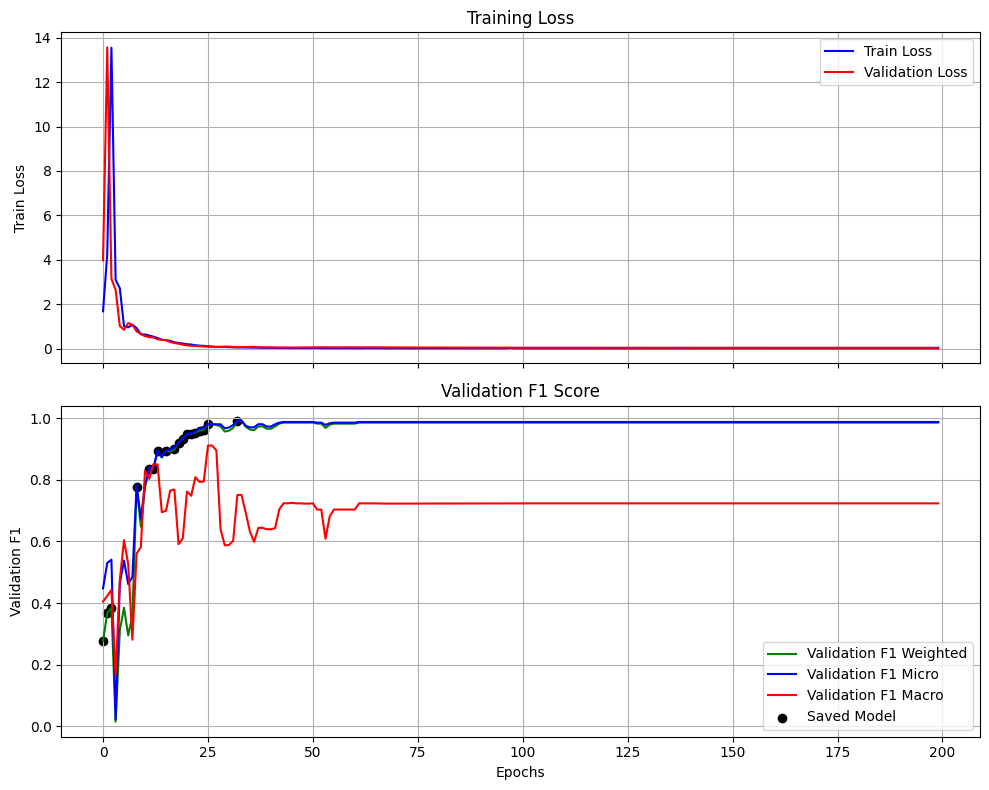

In [27]:
plot_training_process()

In [28]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    class_degree_report = {}
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        epsilon = 1e-6 # to avoid division by zero
        avg_influence = (avg_out ** 2) / ((avg_in + epsilon) * WINDOW_SIZE)
        max_influence = (max_out ** 2) / ((min_in + epsilon) * WINDOW_SIZE)
        min_influence = (min_out ** 2) / ((max_in + epsilon) * WINDOW_SIZE)

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")
        print(f"    Influence: {avg_influence:.4f} | Min: {min_influence:.4f} | Max: {max_influence:.4f}")

        class_degree_report[le.inverse_transform([cls])[0]] = {
            "avg_out": avg_out,
            "min_out": min_out,
            "max_out": max_out,
            "avg_in": avg_in,
            "min_in": min_in,
            "max_in": max_in,
            "avg_influence": avg_influence,
            "min_influence": min_influence,
            "max_influence": max_influence
        }

    return class_degree_report

class_degree_report = check_global_avg_degrees_per_class(test_graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 919.3038 | Min: 1 | Max: 3500
    Avg In-Degree (dst): 3057.8947 | Min: 1 | Max: 3500
    Influence: 0.0790 | Min: 0.0000 | Max: 3499.9965
  Attack Class ['DoS']:
    Avg Out-Degree (src): 997.9920 | Min: 1 | Max: 3500
    Avg In-Degree (dst): 997.9920 | Min: 1 | Max: 3500
    Influence: 0.2851 | Min: 0.0000 | Max: 3499.9965
  Attack Class ['Normal']:
    Avg Out-Degree (src): 2.2143 | Min: 1 | Max: 10
    Avg In-Degree (dst): 1.7222 | Min: 1 | Max: 4
    Influence: 0.0008 | Min: 0.0001 | Max: 0.0286
  Attack Class ['Reconnaissance']:
    Avg Out-Degree (src): 665.1905 | Min: 1 | Max: 1393
    Avg In-Degree (dst): 735.2105 | Min: 1 | Max: 3485
    Influence: 0.1720 | Min: 0.0000 | Max: 554.4134


In [29]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    # Check if dataset is a list of (data, label) tuples or just data objects
    if isinstance(dataset[0], (list, tuple)):
        data_obj = dataset[0][0]
    else:
        data_obj = dataset[0]

    num_features = data_obj.edge_attr.shape[1]
    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=len(class_map)).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)

    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)
    
    return classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, output_dict=True, labels=range(len(class_map)))


print("Number of test graphs: ", len(test_graph_dataset))
normal_report = eval(test_graph_dataset)


Number of test graphs:  158
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.9832
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283466   7000      0      0     34]
 [   959 247532      4      0      5]
 [     0      0     31      0      0]
 [     0      1     68  12695   1205]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9966    0.9758    0.9861    290500
           DoS     0.9725    0.9961    0.9842    248500
        Normal     0.3010    1.0000    0.4627        31
Reconnaissance     1.0000    0.9088    0.9522     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9832    553000
     macro avg     0.6540    0.7761    0.6770    553000
  weighted avg     0.9858    0.9832    0.9843    553000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_node_type='both', random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    if to_node_type == 'src':
         to_nodes = edge_index[0]

    elif to_node_type == 'dst':
         to_nodes = edge_index[1]

    elif to_node_type == 'both':
         to_nodes = th.cat([edge_index[0], edge_index[1]])

    else:
        raise ValueError("to_node_type must be 'src', 'dst', or 'both'.")

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []
    
    for i in range(num_to_inject):
        rng = random.Random(random_seed + i)  # ensure different seed per iteration
        src = rng.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = rng.choice(to_nodes.tolist())  # to existing nodes

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [31]:
# Inject Attack Traffic to Attacker Nodes
inject_both_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='both') for g in test_graph_dataset]
inject_both_report = eval(inject_both_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.4895
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [27975 26639     1   685     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[290499      1      0      0      0]
 [248494      6      0      0      0]
 [     0      1     30      0      0]
 [  5437   1237      3   7221     71]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.5336    1.0000    0.6959    290500
           DoS     0.0048    0.0000    0.0000    248500
        Normal     0.9091    0.9677    0.9375        31
Reconnaissance     1.0000    0.5169    0.6815     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.5384    553000
     macro avg     0.4895    0.4969    0.4630    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [32]:
# Inject Attack Traffic to Attacker Nodes
inject_src_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='src') for g in test_graph_dataset]
inject_src_report = eval(inject_src_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.4882
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 1337 53602     0   361     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[290496      4      0      0      0]
 [248490     10      0      0      0]
 [     0      0     31      0      0]
 [  6137   1284      6   6441    101]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.5329    1.0000    0.6953    290500
           DoS     0.0077    0.0000    0.0001    248500
        Normal     0.8378    1.0000    0.9118        31
Reconnaissance     1.0000    0.4611    0.6312     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.5370    553000
     macro avg     0.4757    0.4922    0.4477    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:
# Inject Attack Traffic to Attacker Nodes
inject_dst_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='dst') for g in test_graph_dataset]
inject_dst_report = eval(inject_dst_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Test Accuracy: 0.8938
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [28447 25461     6  1386     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283466   7000      0      0     34]
 [   959 247532      2      2      5]
 [     0      0     31      0      0]
 [     0      1     68  12695   1205]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9966    0.9758    0.9861    290500
           DoS     0.9725    0.9961    0.9842    248500
        Normal     0.3069    1.0000    0.4697        31
Reconnaissance     0.9998    0.9088    0.9521     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9832    553000
     macro avg     0.6552    0.7761    0.6784    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Edge Attribute Perturbation
def perturb_edge_attributes(graph, affected_edge_ratio=0.1, perturbation_ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()

    num_edges = edge_index.size(1)
    feature_dim = edge_attr.size(1)

    # Randomly select edges to perturb
    num_to_perturb = max(1, int(affected_edge_ratio * num_edges))
    rng = random.Random(random_seed)
    indices_to_perturb = rng.sample(range(num_edges), num_to_perturb)

    for idx in indices_to_perturb:
        # Perturb the edge attributes by adding noise
        noise = th.randn(feature_dim) * perturbation_ratio  # Adjust the scale of noise as needed
        edge_attr[idx] += noise

    # Create a new graph with perturbed attributes
    perturbed_graph = Data(edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label, x=graph.x)

    return perturbed_graph

In [35]:
# Edge Attribute Perturbation
edge_perturb_graph_dataset = [perturb_edge_attributes(g.cpu(), affected_edge_ratio=1, perturbation_ratio=1) for g in test_graph_dataset]
edge_perturb_report = eval(edge_perturb_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.9769
Adversarial confusion matrix: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283499   7001      0      0      0]
 [  4473 244022      4      0      1]
 [     0      0     31      0      0]
 [     0      1     68  12695   1205]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9845    0.9759    0.9802    290500
           DoS     0.9721    0.9820    0.9770    248500
        Normal     0.3010    1.0000    0.4627        31
Reconnaissance     1.0000    0.9088    0.9522     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9769    553000
     macro avg     0.6515    0.7733    0.6744    553000
  weighted avg     0.9793    0.9769    0.9780    553000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [36]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for i in range(num_injected_edges):
        rng = random.Random(random_seed + i)  # ensure different seed per edge
        src = rng.randint(0, num_nodes - 1)  # Random source node
        dst = rng.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [37]:
# Inject Random Edges
random_edge_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
random_edge_report = eval(random_edge_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.5035
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [53076   665   252   769   538     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[290500      0      0      0      0]
 [243188   5312      0      0      0]
 [     2      1     12     12      4]
 [  1206      0      0  10458   2305]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.5431    1.0000    0.7039    290500
           DoS     0.9998    0.0214    0.0419    248500
        Normal     1.0000    0.3871    0.5581        31
Reconnaissance     0.9989    0.7487    0.8558     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.5539    553000
     macro avg     0.7084    0.4314    0.4319    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [38]:
def compare_overall_metrics(baseline_report, adversarial_reports, class_degree_report):
    rows = []   
    metrics = ['precision', 'recall', 'f1-score']
    eplison = 1e-10  # To avoid division by zero

    for label in list(class_map) + ['macro avg', 'weighted avg']:
        row = {"Class": label}
        row['Class'] = label
        row['Min Influence'] = class_degree_report[label]['min_influence'] if label in class_degree_report else 0.0
        row['Avg Influence'] = class_degree_report[label]['avg_influence'] if label in class_degree_report else 0.0
        row['Max Influence'] = class_degree_report[label]['max_influence'] if label in class_degree_report else 0.0
        for metric in metrics:
            baseline_val = baseline_report[label][metric]
            row[f"Normal {metric}"] = baseline_val
            for name, report in adversarial_reports.items():
                adv_val = report[label][metric]
                row[f"{name} {metric}"] = adv_val
                row[f"{name} {metric} Drop (%)"] = ((baseline_val - adv_val) / (baseline_val + eplison)) * 100
        row['support'] = int(baseline_report[label]['support'])
        rows.append(row)

    return pd.DataFrame(rows)

adversarial_reports = {
    "To Both": inject_both_report,
    "To Src": inject_src_report,
    "To Dst": inject_dst_report,
    "Edge Perturbation": edge_perturb_report,
    "Random Edge": random_edge_report,
}

comparison_df = compare_overall_metrics(normal_report, adversarial_reports, class_degree_report)

class_col = comparison_df['Class']
support_df = comparison_df['support']
normal_cols = [col for col in comparison_df.columns if col.startswith('Normal')] 
influence_cols = [col for col in comparison_df.columns if col.endswith('Influence')] 
influence_df = comparison_df[influence_cols]
f1_cols = [col for col in comparison_df.columns if col.endswith('f1-score')]
f1_drop_cols = [col for col in comparison_df.columns if col.endswith('f1-score Drop (%)')]

baselines_df = pd.concat([class_col, support_df, influence_df], axis=1)

f1_df = pd.concat([baselines_df, comparison_df[f1_cols]], axis=1)
f1_drop_df = pd.concat([baselines_df, comparison_df[f1_drop_cols]], axis=1)

print("Comparison of Overall Metrics:")
display(comparison_df.style.set_caption("Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))


Comparison of Overall Metrics:


,Class,Min Influence,Avg Influence,Max Influence,Normal precision,To Both precision,To Both precision Drop (%),To Src precision,To Src precision Drop (%),To Dst precision,To Dst precision Drop (%),Edge Perturbation precision,Edge Perturbation precision Drop (%),Random Edge precision,Random Edge precision Drop (%),Normal recall,To Both recall,To Both recall Drop (%),To Src recall,To Src recall Drop (%),To Dst recall,To Dst recall Drop (%),Edge Perturbation recall,Edge Perturbation recall Drop (%),Random Edge recall,Random Edge recall Drop (%),Normal f1-score,To Both f1-score,To Both f1-score Drop (%),To Src f1-score,To Src f1-score Drop (%),To Dst f1-score,To Dst f1-score Drop (%),Edge Perturbation f1-score,Edge Perturbation f1-score Drop (%),Random Edge f1-score,Random Edge f1-score Drop (%),support
0,DDoS,0.00,0.08,3500.00,1.00,0.53,46.46,0.53,46.53,1.00,0.00,0.98,1.22,0.54,45.51,0.98,1.00,-2.48,1.00,-2.48,0.98,0.00,0.98,-0.01,1.00,-2.48,0.99,0.70,29.43,0.70,29.49,0.99,0.00,0.98,0.60,0.70,28.62,290500
1,DoS,0.00,0.29,3500.00,0.97,0.00,99.50,0.01,99.21,0.97,0.00,0.97,0.04,1.00,-2.81,1.00,0.00,100.00,0.00,100.00,1.00,0.00,0.98,1.42,0.02,97.85,0.98,0.00,100.00,0.00,99.99,0.98,0.00,0.98,0.73,0.04,95.75,248500
2,Normal,0.00,0.00,0.03,0.30,0.91,-202.05,0.84,-178.38,0.31,-1.98,0.30,0.00,1.00,-232.26,1.00,0.97,3.23,1.00,0.00,1.00,0.00,1.00,0.00,0.39,61.29,0.46,0.94,-102.62,0.91,-97.06,0.47,-1.52,0.46,0.00,0.56,-20.63,31
3,Reconnaissance,0.00,0.17,554.41,1.00,1.00,0.00,1.00,0.00,1.00,0.02,1.00,0.00,1.00,0.11,0.91,0.52,43.12,0.46,49.26,0.91,0.00,0.91,0.00,0.75,17.62,0.95,0.68,28.43,0.63,33.72,0.95,0.01,0.95,0.00,0.86,10.12,13969
4,Theft,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
5,macro avg,0.00,0.00,0.00,0.65,0.49,25.16,0.48,27.27,0.66,-0.18,0.65,0.38,0.71,-8.31,0.78,0.50,35.97,0.49,36.58,0.78,0.00,0.77,0.36,0.43,44.41,0.68,0.46,31.61,0.45,33.88,0.68,-0.20,0.67,0.39,0.43,36.20,553000
6,weighted avg,0.00,0.00,0.00,0.99,0.31,68.78,0.31,68.69,0.99,0.00,0.98,0.67,0.76,22.92,0.98,0.54,45.24,0.54,45.38,0.98,0.00,0.98,0.64,0.55,43.67,0.98,0.38,61.11,0.38,61.27,0.98,0.00,0.98,0.64,0.41,58.32,553000


In [39]:
# Check F1 Scores
display(f1_df.style.background_gradient(cmap='Greens', subset=f1_cols, axis=0).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,Normal f1-score,To Both f1-score,To Src f1-score,To Dst f1-score,Edge Perturbation f1-score,Random Edge f1-score
0,DDoS,290500,0.00,0.08,3500.00,0.99,0.70,0.70,0.99,0.98,0.70
1,DoS,248500,0.00,0.29,3500.00,0.98,0.00,0.00,0.98,0.98,0.04
2,Normal,31,0.00,0.00,0.03,0.46,0.94,0.91,0.47,0.46,0.56
3,Reconnaissance,13969,0.00,0.17,554.41,0.95,0.68,0.63,0.95,0.95,0.86
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,553000,0.00,0.00,0.00,0.68,0.46,0.45,0.68,0.67,0.43
6,weighted avg,553000,0.00,0.00,0.00,0.98,0.38,0.38,0.98,0.98,0.41


In [40]:
# Compare Drops per Adversarial Attack
display(f1_drop_df[f1_drop_df['Class'] == 'weighted avg'].style.background_gradient(cmap='Reds', subset=f1_drop_cols, axis=None).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
6,weighted avg,553000,0.00,0.00,0.00,61.11,61.27,0.00,0.64,58.32


In [41]:
# Compare Drops per Class
display(f1_drop_df.style.background_gradient(cmap='Reds', subset=f1_drop_cols).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
0,DDoS,290500,0.00,0.08,3500.00,29.43,29.49,0.00,0.60,28.62
1,DoS,248500,0.00,0.29,3500.00,100.00,99.99,0.00,0.73,95.75
2,Normal,31,0.00,0.00,0.03,-102.62,-97.06,-1.52,0.00,-20.63
3,Reconnaissance,13969,0.00,0.17,554.41,28.43,33.72,0.01,0.00,10.12
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,553000,0.00,0.00,0.00,31.61,33.88,-0.20,0.39,36.20
6,weighted avg,553000,0.00,0.00,0.00,61.11,61.27,0.00,0.64,58.32


In [ ]:
from collections import defaultdict
from pprint import pformat

def round_tuple(t):
    return tuple(round(x, 2) for x in t)

def print_results(class_degree_report, comparison_df):
    report_dict = defaultdict(dict)

    for class_name, metrics in class_degree_report.items():
        report_dict[class_name] = {
            "influence": round_tuple((metrics['min_influence'], metrics['avg_influence'], metrics['max_influence'])),
            "out_degree": round_tuple((metrics['min_out'], metrics['avg_out'], metrics['max_out'])),
            "in_degree": round_tuple((metrics['min_in'], metrics['avg_in'], metrics['max_in']))
        }

    for _, row in comparison_df.iterrows():
        class_name = row['Class']
        if class_name == 'weighted avg':
            class_name = 'Weighted Average'
        report_dict[class_name].update({
            "normal_f1": round(row['Normal f1-score'], 2),
            "to_both_f1": round(row['To Both f1-score'], 2),
            "to_src_f1": round(row['To Src f1-score'], 2),
            "to_dst_f1": round(row['To Dst f1-score'], 2),
            "edge_perturb_f1": round(row['Edge Perturbation f1-score'], 2),
            "random_edge_f1": round(row['Random Edge f1-score'], 2),
        })

    print("Final Report:")
    print(pformat(dict(report_dict), sort_dicts=False, indent=1))

print_results(class_degree_report, comparison_df)

Final Report:
{'DDoS': {'influence': (0.0, 0.08, 3500.0),
          'out_degree': (1.0, 919.3, 3500.0),
          'in_degree': (1.0, 3057.89, 3500.0),
          'normal_f1': 0.99,
          'to_both_f1': 0.7,
          'to_src_f1': 0.7,
          'to_dst_f1': 0.99,
          'edge_perturb_f1': 0.98,
          'random_edge_f1': 0.7},
 'DoS': {'influence': (0.0, 0.29, 3500.0),
         'out_degree': (1.0, 997.99, 3500.0),
         'in_degree': (1.0, 997.99, 3500.0),
         'normal_f1': 0.98,
         'to_both_f1': 0.0,
         'to_src_f1': 0.0,
         'to_dst_f1': 0.98,
         'edge_perturb_f1': 0.98,
         'random_edge_f1': 0.04},
 'Normal': {'influence': (0.0, 0.0, 0.03),
            'out_degree': (1.0, 2.21, 10.0),
            'in_degree': (1.0, 1.72, 4.0),
            'normal_f1': 0.46,
            'to_both_f1': 0.94,
            'to_src_f1': 0.91,
            'to_dst_f1': 0.47,
            'edge_perturb_f1': 0.46,
            'random_edge_f1': 0.56},
 'Reconnaissance': {'i

: 